# Group Members:

Caelan Cheyne (caelancheyne@arizona.edu)
Ameya Madhugiri (amadhugiri@arizona.edu)
Ethan Olla (Ethano1@arizona.edu)

# Introduction:

In 2022, 1,190,211 Americans were the victims of violent crime (FBI, 2024), making crime prevention one of the largest issues in America. One key aspect surrounding crime prevention are streetlights. Streetlights may sound like an ineffective method to stop crime, however research from the National Council for Crime Prevention, Sweden, shows that, “improved street lighting significantly reduces crime” (Welsh, Farrington, 2008). Additional studies from multiple countries (USA, UK, Brazil, and South Korea) back these findings and show that crime is reduced by 14-20% in areas that feature streetlights (Welsh, et al, 2020). Researcher Dr. Brandon Welsch theorizes two keyways that streetlights may affect crime. The first is that streetlights increase surveillance and deter would-be criminals from breaking the law. The second is that streetlights themselves don’t make a major impact on crime but are rather an indicator for a wealthier area (Welsh, Farrington, 2008). Wealth being one of the strongest predictors of crime rates (Anser, et al, 2020). Building on Dr. Brandon Welsh’s theories, our project aims to determine if streetlights decrease night crime in Tucson, Arizona, or if streetlights are just a marker for higher income areas. To do this we will analyze neighborhood income data in comparison with arrest data to ensure we can use income data as a model for predicting crime in Tucson. We will then compare the location of streetlights in Tucson to our income model, to see if street lights affect crime rates in Tucson beyond what our income-based model predicts.

 **Beginning Hypothesis: Street lights in Tucson reduce arrests because they deter criminals, not because they are an economic marker.**


Import libraries

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score
from datetime import datetime
from scipy.stats import pearsonr
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Looking at the information provided in the different data files, we found that that a significant portion of entries in reported crimes were not geocoded, and of those that were, many were concentrated by landmarks and not specific addresss's. On the other hand, a larger portion of arrests were geocoded, and were marked with much greater accuracy. Therefore we decided to use arrests as a representative dataset going forward.

# Import Files

Import Files from drive and print out the first 2 lines to confirm the files were imported correctly.

In [ ]:
arrest_data_gj = gpd.read_file('/content/drive/My Drive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.geojson')

arrest_data_gj.head(2)

,OBJECTID,X,Y,arre_id,case_id,agency,date_arr,time_arr,datetime_arr,MONTH_ARR,...,WARD,NHA_NAME,TMSECT,DIVISION,DIVISION_NO,DIVSECT,TRSQ,City_geo,ADDRESS_100BLK,geometry
0,1,990008.859049,470751.276735,2021000107,2101020104,TPD,2021-01-02 00:00:00+00:00,1731,2021-01-02 17:31:00+00:00,01-Jan,...,3,None,None,Operations Division West,T2,T203,13S13E24NW,TUCSON,4598 N ORACLE RD,POINT (-110.97816 32.29069)
1,2,990008.859049,470751.276735,2021000107,2101020104,TPD,2021-01-02 00:00:00+00:00,1731,2021-01-02 17:31:00+00:00,01-Jan,...,3,None,None,Operations Division West,T2,T203,13S13E24NW,TUCSON,4598 N ORACLE RD,POINT (-110.97816 32.29069)


In [ ]:
streetlight_data_gj = gpd.read_file('/content/drive/My Drive/datasets/Streetlights_-_City_of_Tucson_-_Open_Data.geojson')
streetlight_data_gj.head(2)

,OBJECTID,Model,Type,Bulb_Type,Wattage,Voltage,Address_Number,Street,City,Light_Fixture_Theme,DATASOURCE,Permit_Number,CartegraphID,SHAPE,Retired,Status,MacID,TEP_Account_Number,Power_Pedestal_ID,geometry
0,1,ATBM D R3,Autobahn,LED,95.0,480.0,5425.0,S Campbell Av,Tucson,Other,TDOT_STREETLIGHTS,,51,None,NaT,Active,00F14C41,3710003318,514,POINT (-110.94331 32.15373)
1,2,ATBM D R3,Autobahn,LED,95.0,480.0,5434.0,S Campbell Av,Tucson,Other,TDOT_STREETLIGHTS,,52,None,NaT,Active,00F10A57,3710003318,514,POINT (-110.9436 32.15341)


In [ ]:
income_data_gj = gpd.read_file('/content/drive/My Drive/datasets/Neighborhood_Income.geojson')
income_data_gj.head(2)

,OBJECTID,NAME,WARD,DATASOURCE,ID,sourceCountry,ENRICH_FID,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,...,ID_1,sourceCountry_1,ENRICH_FID_1,aggregationMethod_1,populationToPolygonSizeRating_1,apportionmentConfidence_1,HasData_1,TOTHH_CY,WLTHINDXCY,geometry
0,1,A Mountain,1,NEIGHBORHOODS,0,US,1,BlockApportionment:US.BlockGroups,2.191,2.576,...,0,US,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,1103,32,"POLYGON ((-111.0076 32.20691, -111.00673 32.20..."
1,2,Adelanto,3,NEIGHBORHOODS,1,US,2,BlockApportionment:US.BlockGroups,2.191,2.576,...,1,US,2,BlockApportionment:US.BlockGroups,2.191,2.576,1,117,28,"POLYGON ((-110.98426 32.24578, -110.98222 32.2..."


# Cleaning the Data:

**Cleaning arrest data:**

Let's take a look at what columns are useful to us:

*   Geometry: This gives a point with the latitude and longitude of the arrest location.

*   datetime_arr: This column contains both the date and time for each arrest. We need this information, but the columns date_arr and time_arr also contain this information. Which do we use? date_arr and datetime_arr both contain the date in the same format, so we can seperate the date from either of these (we will choose date_arr). To get the time data from datetime_arr we would need to process every item and convert from the format xx:xx:xx+xx, to just an Integer. To avoid this process it is easier to take the data from time_arr, as it is already formatted in it's integer form.



The other columns contain repeated or unnecessary information for this report. Let's get rid of them below.

In [ ]:
# Selecting useful columns
arrest_essentials = arrest_data_gj[['date_arr', 'time_arr', 'geometry']].copy()

# Renaming columns for clarity
arrest_essentials.rename(columns={
    'date_arr': 'date',
    'time_arr': 'time',
}, inplace=True)

# Remove time part from the 'date' column
arrest_essentials['date'] = pd.to_datetime(arrest_essentials['date']).dt.date

# Display the cleaned data
arrest_essentials.head(2)

,date,time,geometry
0,2021-01-02,1731,POINT (-110.97816 32.29069)
1,2021-01-02,1731,POINT (-110.97816 32.29069)


Let's plot this data to make sure we have an accurate arrests dataset.

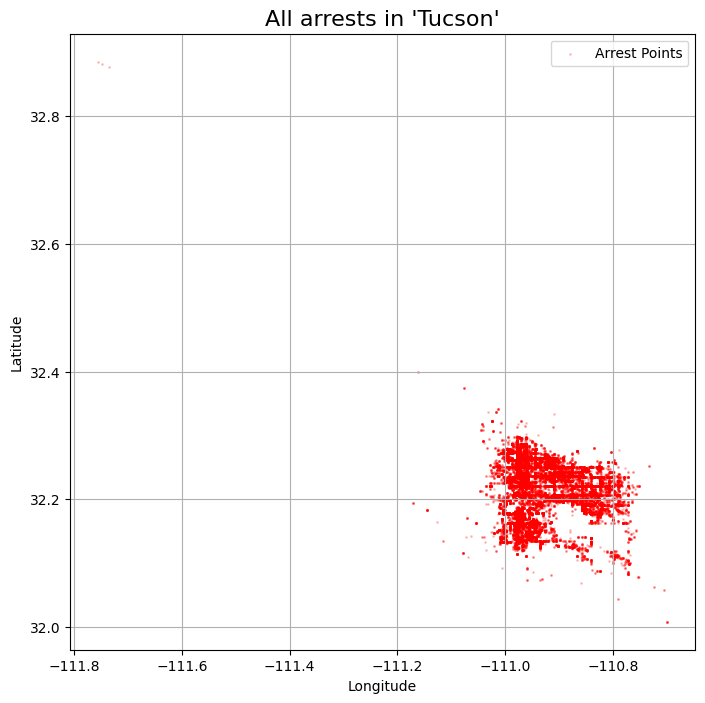

In [ ]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the points
arrest_essentials.plot(ax=ax, color='red', markersize=1, label='Arrest Points', alpha = 0.2)

# Add labels and legend
plt.title("All arrests in 'Tucson'", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()

# Show the map
plt.show()

As we can see some of our arrest data comes from places far away from Tucson, specifically on the road heading to Pheonix. These arrests aren't useful for our data as they occur as on roads and our mostly traffic stops.
To fix this we will filter outall arrests except those in neighborhoods

**Cleaning income & neighborhood data**

Lets take a look at what data we need from the income dataset:

*   NAME: name is important as it is the only way to identify each neighborhood
*   median_income: we choose median income as it best represents a neighborhood. Something like average_income could easily be skewed by a few rich outliers, whereas poor outliers would sway the data less.

*   geometry: necessary to plot the neighborhoods and identify which arrests took place inside certain neighborhoods.

*   HasData columns: allows us to verify that our datasets are not empty
*   TOTHH_CY: provides the total households which we use to normalize the data for each neighborhood.



In [ ]:
# Select useful columns
income_essentials = income_data_gj[['NAME', 'MEDHINC_CY', 'geometry', 'HasData', 'HasData_1', 'TOTHH_CY']].copy()

# Rename columns for clarity
income_essentials.rename(columns={
    'NAME': 'neighborhood',
    'MEDHINC_CY': 'median_income',
    'HasData': 'has_data',
    'HasData_1': 'has_data_1',
    'TOTHH_CY': 'total_households'
}, inplace=True)

#
income_essentials = income_essentials[income_essentials['has_data'] == 1]
income_essentials.drop(columns=['has_data'], inplace=True)
income_essentials.drop(columns=['has_data_1'], inplace=True)

# Display the cleaned data
print(income_essentials)

              neighborhood  median_income  \
0               A Mountain          39293   
1                 Adelanto          33635   
2         Alvernon Heights          29762   
3                    Amphi          20213   
4              Armory Park          36870   
..                     ...            ...   
154  West Lamar City Acres          38082   
155             Loma Verde          43696   
156               Downtown          36471   
157      Barrio Santa Cruz          27188   
158                Bonanza          62571   

                                              geometry  total_households  
0    POLYGON ((-111.0076 32.20691, -111.00673 32.20...              1103  
1    POLYGON ((-110.98426 32.24578, -110.98222 32.2...               117  
2    POLYGON ((-110.90819 32.20294, -110.90818 32.2...                99  
3    POLYGON ((-110.97768 32.27921, -110.97731 32.2...              3105  
4    POLYGON ((-110.97102 32.22046, -110.97112 32.2...              1223  
..       

**Cleaning streetlight data**

Lets take a look at what data we need from the streetlight dataset:

*   Status: we will use this to preprocess the inactive streetlights out of our dataset
*   geometry: we will use the geometry to find the location of streetlights

Also to note: we only care about active streetlights, as an inactive streetlight is the same as no streetlight, so we filter these out.

In [ ]:
# Select useful columns
streetlight_essentials = streetlight_data_gj[['Status', 'geometry']].copy()

#shows that we have ['Active' 'Inactive' 'Canceled' None] streetlight stati
print(streetlight_essentials['Status'].unique())

streetlight_essentials = streetlight_essentials[streetlight_essentials['Status'] == 'Active']

#shows that we now only have active streetlights
print(streetlight_essentials['Status'].unique())

# Display the cleaned data
streetlight_essentials.head(2)

['Active' 'Inactive' 'Canceled' None]
['Active']


,Status,geometry
0,Active,POINT (-110.94331 32.15373)
1,Active,POINT (-110.9436 32.15341)



# Creating DataFrames

Function for seeing if a time is between sunset and sunrise in Tucson given the month and a time.

In [ ]:
def is_nighttime(date: datetime, time: int) -> bool:
    """
    Determine if a given date and time fall during the nighttime based on sunset and sunrise times.

    Parameters:
    - date (str): Date in the format 'yyyy-mm-dd'
    - time (str): Time in military format (e.g., '2130' for 9:30 PM)

    Returns:
    - bool: True if the time is nighttime (after sunset or before sunrise), False otherwise
    """
    sun_times = {
        1: [1715, 730],  # January
        2: [1745, 710],  # February
        3: [1815, 645],  # March
        4: [1845, 615],  # April
        5: [1900, 545],  # May
        6: [1915, 530],  # June
        7: [1915, 535],  # July
        8: [1900, 550],  # August
        9: [1845, 615],  # September
        10: [1815, 645],  # October
        11: [1715, 705],  # November
        12: [1700, 730],  # December
    }

    # Extract the month from the input date
    month = date.month

    # Get sunset and sunrise times for the month
    sunset, sunrise = sun_times[month]

    # Determine if the time is nighttime
    return time >= sunset or time <= sunrise


Confirm all datasets are formatted to the same coordinate reference system, If they are join relevant sets. Looking through data there are some neighborhoods with no streetlights and/or no arrests, so we will fill the naN with 0's to account

In [ ]:
# Making sure coordinate systems are the same so we can join
print("Income CRS:", income_essentials.crs)
print("Arrests CRS:", arrest_essentials.crs)
print("Streetlights CRS:", streetlight_essentials.crs)

# create a new data frame containing only arrests within income data neighborhoods
arrests_within_neighborhoods = gpd.sjoin(
    arrest_essentials, income_essentials, how='inner', predicate='within'
)

#remove all other arrests
filtered_arrest_data = arrest_essentials[arrest_essentials.index.isin(arrests_within_neighborhoods.index)]

#convert time string into time int
arrests_within_neighborhoods['time'] = pd.to_numeric(arrests_within_neighborhoods['time'], errors='coerce').fillna(0).astype(int)

# Add a column to filter nighttime arrests
arrests_within_neighborhoods['is_nighttime'] = arrests_within_neighborhoods.apply(
    lambda row: is_nighttime(row['date'], row['time']), axis=1
)
# Separate nighttime arrests
nighttime_arrests = arrests_within_neighborhoods[arrests_within_neighborhoods['is_nighttime']]

streetlights_within_neighborhoods = gpd.sjoin(
    streetlight_essentials, income_essentials, how='inner', predicate='within'
)
#filtering out streetlights not in neighborhoods
filtered_streetlight_data = streetlight_essentials[streetlight_essentials.index.isin(streetlights_within_neighborhoods.index)]



# Aggregate data by neighborhood
arrest_counts_by_neighborhood = arrests_within_neighborhoods.groupby('neighborhood').size().reset_index(name='arrest_count')
nighttime_arrest_counts = nighttime_arrests.groupby('neighborhood').size().reset_index(name='nighttime_arrest_count')
streetlight_counts_by_neighborhood = streetlights_within_neighborhoods.groupby('neighborhood').size().reset_index(name='streetlight_count')

# Combine data into a single dataframe
combined_frame = pd.merge(
    arrest_counts_by_neighborhood,
    streetlight_counts_by_neighborhood,
    on='neighborhood',
    how='outer'  # Include neighborhoods with missing data
)
combined_frame = pd.merge(
    combined_frame,
    nighttime_arrest_counts,
    on='neighborhood',
    how='outer'
)

#replacing naN with 0's since we have only valid data now, and all naN are actually 0
combined_frame['nighttime_arrest_count'] = combined_frame['nighttime_arrest_count'].fillna(0).astype(int)

combined_frame = pd.merge(
    combined_frame,
    income_essentials[['neighborhood', 'median_income', 'total_households']],
    on='neighborhood',
    how='outer'
)

# Fill missing values with 0
combined_frame.fillna(0, inplace=True)

# Add calculated columns: arrests_per_household, streetlights_per_household, and nighttime_arrests_per_household
combined_frame['arrests_per_household'] = combined_frame['arrest_count'] / combined_frame['total_households'].replace(0, 1)
combined_frame['streetlights_per_household'] = combined_frame['streetlight_count'] / combined_frame['total_households'].replace(0, 1)
combined_frame['nighttime_arrests_per_household'] = combined_frame['nighttime_arrest_count'] / combined_frame['total_households'].replace(0, 1)

# Replace NaN in nighttime_arrests_per_household with 0
combined_frame['nighttime_arrests_per_household'] = combined_frame['nighttime_arrests_per_household'].fillna(0)


# Add a binary indicator for neighborhoods with nighttime arrests
combined_frame['has_nighttime_arrests'] = (combined_frame['nighttime_arrest_count'] > 0).astype(int)

# Convert streetlight_count to integer if needed
combined_frame['streetlight_count'] = combined_frame['streetlight_count'].astype(int)

# Print the final combined frame
print(combined_frame)

Income CRS: EPSG:4326
Arrests CRS: EPSG:4326
Streetlights CRS: EPSG:4326
             neighborhood  arrest_count  streetlight_count  \
0              A Mountain         100.0                130   
1                Adelanto           5.0                 42   
2             Aldea Linda           0.0                  4   
3        Alvernon Heights          35.0                 24   
4                   Amphi        1516.0                196   
..                    ...           ...                ...   
153       West University         607.0                709   
154      Western Hills II          23.0                107   
155  Westside Development          77.0                 35   
156      Wilshire Heights           4.0                  3   
157           Winterhaven          26.0                 47   

     nighttime_arrest_count  median_income  total_households  \
0                      55.0          39293              1103   
1                       5.0          33635            

Exploration: **Sanity check** to make sure we can use geopandas to check if points are within a polygon.

number of houses in midvale park:


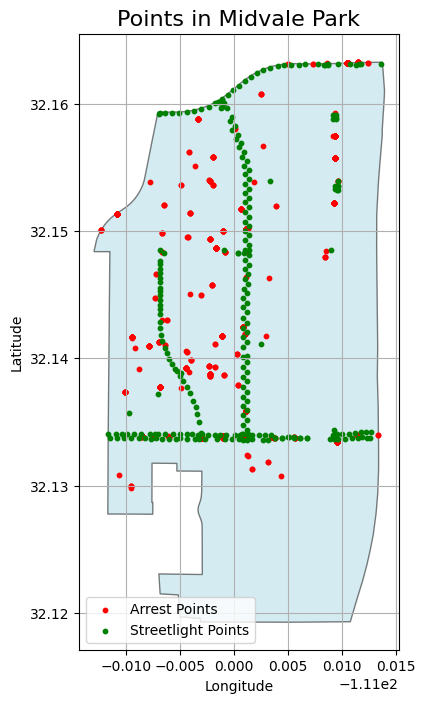

Number of arrests in Midvale Park: 1381


In [ ]:
#setting up polygon
midvale_park_polygon = income_essentials[income_essentials['neighborhood'] == 'Midvale Park']


#setting up datasets
arrests_in_midvale_park = arrests_within_neighborhoods[
    arrests_within_neighborhoods['neighborhood'] == 'Midvale Park'
]

streetlights_within_midvale_park = streetlights_within_neighborhoods[
    streetlights_within_neighborhoods['neighborhood'] == 'Midvale Park'
]

print(f"number of houses in midvale park:")



# make area
fig, ax = plt.subplots(figsize=(10, 8))

#plot the polygon
midvale_park_polygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

#plot
arrests_in_midvale_park.plot(ax=ax, color='red', markersize=10, label='Arrest Points')
streetlights_within_midvale_park.plot(ax=ax, color='green', markersize=10, label='Streetlight Points')

# general labels and legend
plt.title("Points in Midvale Park", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()

# Show the map
plt.show()

print(f"Number of arrests in Midvale Park: {len(arrests_in_midvale_park)}")


# Plotting all arrests made in neighborhoods in Tucson

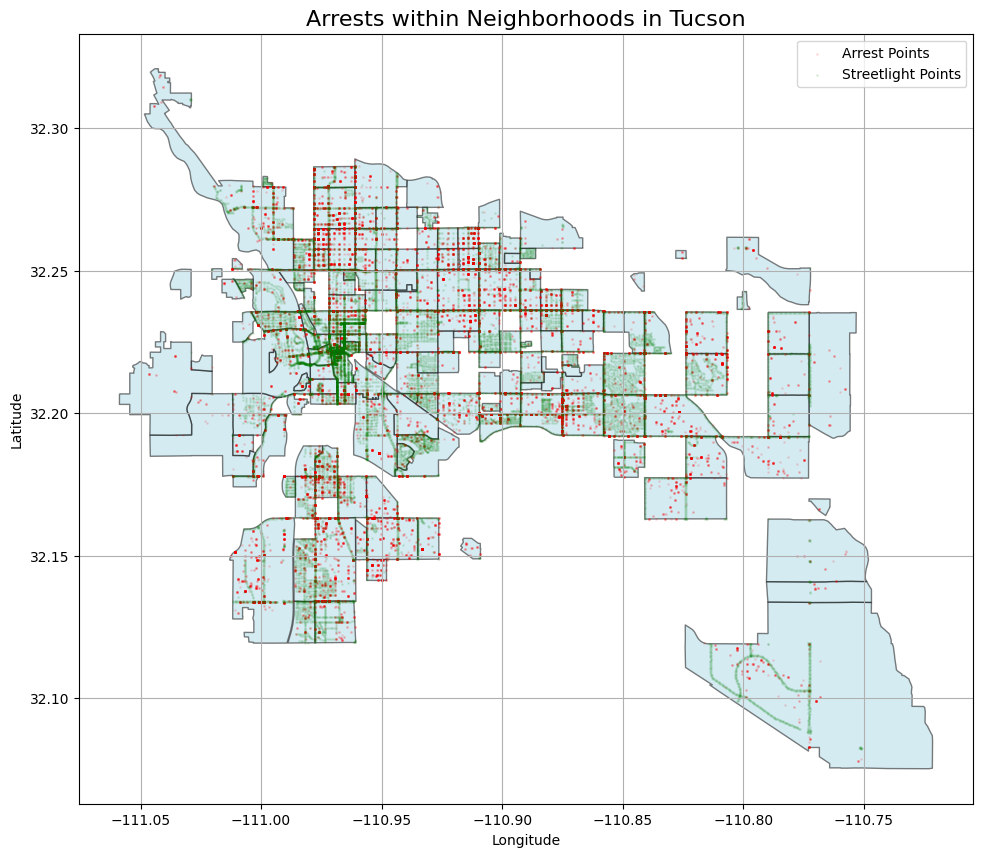

In [ ]:
# Plot the map
fig, ax = plt.subplots(figsize=(15, 10))

all_neighborhood_polygon = income_essentials.geometry
all_neighborhood_polygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)

# Plot the arrests
filtered_arrest_data.plot(ax=ax, color='red', markersize=1, label='Arrest Points', alpha = 0.1)
filtered_streetlight_data.plot(ax=ax, color='green', markersize=1, label='Streetlight Points', alpha = 0.1)

# Label Graph
plt.title("Arrests within Neighborhoods in Tucson", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid()

# Show the map
plt.show()

# **Methodology**

Our methodology focused on analyzing the relationship between median neighborhood income, streetlight density, and arrest rates in Tucson. First, we cleaned and prepared datasets containing information on arrests, streetlights, and neighborhood income by selecting relevant columns, filtering for accurate data points, and ensuring all datasets were in a uniform coordinate system. Arrests and streetlights were spacially joined with neighborhood polygons to identify their distribution within neighborhoods. We then separated nighttime arrests by determining whether the arrest times fell between sunset and sunrise. To normalize data, we calculated per-household metrics for arrests, nighttime arrests, and streetlights, to make sure all comparisons were fair. For modeling, we used linear regression, decision trees, and random forests, evaluating each with k-fold cross-validation based on mean squared error (MSE). The models were then refined using train-test splits, and performance the metrics MSE and \(R^2\) were calculated. Finally, we make visualization including scatter plots and 3D plots all with regression lines of best fit. These were created to interpret and validate model results.

# **Builiding Models**

**Exploratory:** checking correlations as prelimary step in model building. Found that more streetlights and arrests had a positive correlation. Changed question and hypthesis over this. Also saw that streetlights per household and income were pretty losely corrrelated leading to us dropping that as a question.

In [ ]:
# Correlation tests with ratios
corr_streetlights_arrests, _ = pearsonr(combined_frame['streetlights_per_household'], combined_frame['arrests_per_household'])
corr_income_arrests, _ = pearsonr(combined_frame['median_income'], combined_frame['arrests_per_household'])
corr_stoplights_income, _ = pearsonr(combined_frame['streetlights_per_household'], combined_frame['median_income'])

print(f"Correlation between streetlights per household and arrests per household: {corr_streetlights_arrests}")
print(f"Correlation between income and arrests per household: {corr_income_arrests}")
print(f"Correlation between streetlights per household and income: {corr_stoplights_income}")


Correlation between streetlights per household and arrests per household: 0.9369957242697857
Correlation between income and arrests per household: -0.1326407883726999
Correlation between streetlights per household and income: -0.1254641362732472


Baseline MSE

Revision of Hypothesis: During the exploration of our data we realized that street lights were a stronger predictor of arrests than income, however, the correlation between street lights and arrests was positive. This is a contradiction to a lot of research in the field that has found a negative correlation between street lights and arrests. In order to understand why this was happening we dug deeper into what may make Tucson as a city an outlier. What we found is that Tucson as a city regulates their street lights heavily in order to reduce light pollution. This means that street lights in Tucson appear much less often than most major cities, and are thoughtfully placed, “Intended outcomes [of the outdoor lighting ordinance] include continuing support of astronomical activity and minimizing wasted energy, while not compromising the safety, security, and well being of persons” (Tucson/Pima County, 2023). This policy means that high income/low crime neighborhoods would not receive street lighting like other cities in the US. Whereas low income neighborhoods with high crime would be destinations where street lighting would be deemed necessary, to prevent crime. Thus we see the likely reason why street lights positively correlate with crime in Tucson, because street lights are placed in high crime areas due to predictive policing policies.

**New Hypothesis: Due to Tucson’s predictive policing policies surrounding street lights, can street light locations be used as a better predictor for arrests than traditional methods such as neighborhood income?**


In [ ]:
# Calculate the mean of the target variable
mean_arrest_count = combined_frame['arrests_per_household'].mean()

# Predict the mean for all observations
baseline_predictions = np.full_like(combined_frame['arrests_per_household'], mean_arrest_count)

# Compute the baseline MSE
baseline_mse = mean_squared_error(combined_frame['arrests_per_household'], baseline_predictions)

print("Baseline MSE:", baseline_mse)


Baseline MSE: 0.5524149842772668


# Setup for Modeling

Initalizing our scorer and our three models to test on the data. Also define the k-fold validation being used. We choose 5 folds due to the number (159) of neighborhoods.

In [ ]:

#setup scorer
mse_scorer = make_scorer(mean_squared_error)

# Initialize models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor(max_depth=5, random_state=1000)  # Decision Tree
forest_model = RandomForestRegressor(n_estimators=100, random_state=1000)  # Random Forest

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1000)


#**Predictor: neighborhood median income**
# **Target: arrests per household**

In order to determine which model is the best to use for our data, we will implement three different types of models and choose the best one based on mean square error average after a k-fold validation

In [ ]:
# Define predictors and target
X = combined_frame[['median_income']] # Income as predictor
y = combined_frame['arrests_per_household'] # Arrest count as target


# Perform K-Fold cross-validation for Linear Regression
linear_cv_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=mse_scorer)
linear_avg_mse = np.mean(linear_cv_scores)

# Perform K-Fold cross-validation for Decision Tree
tree_cv_scores = cross_val_score(tree_model, X, y, cv=kf, scoring=mse_scorer)
tree_avg_mse = np.mean(tree_cv_scores)

# Perform K-Fold cross-validation for Random Forest
forest_cv_scores = cross_val_score(forest_model, X, y, cv=kf, scoring=mse_scorer)
forest_avg_mse = np.mean(forest_cv_scores)

# Print average MSE for each model
print(f"Linear Regression Average MSE: {linear_avg_mse:.4f}")
print(f"Decision Tree Average MSE: {tree_avg_mse:.4f}")
print(f"Random Forest Average MSE: {forest_avg_mse:.4f}")


Linear Regression Average MSE: 0.5636
Decision Tree Average MSE: 0.5960
Random Forest Average MSE: 0.5943


Due to linear regression having the lowest MSE score, we will use linear regression to train a model with a train_test_split.

In [ ]:
# Split the data into training and test sets (using random seed of 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Initialize Linear Regression model
income_model = LinearRegression()

# Fit the model on the training data
income_model.fit(X_train, y_train)

# Evaluate the model on the test data
predictions_income = income_model.predict(X_test)

# Evaluate performance metrics
mse_income = mean_squared_error(y_test, predictions_income)
r2_income = r2_score(y_test, predictions_income)

# Results
results_income = {
    "Test Data MSE": mse_income,
    "Test Data R^2": r2_income,
}

results_income


{'Test Data MSE': 0.035503059626454885, 'Test Data R^2': -0.17010640559724055}

Make plot of data + line of best fit


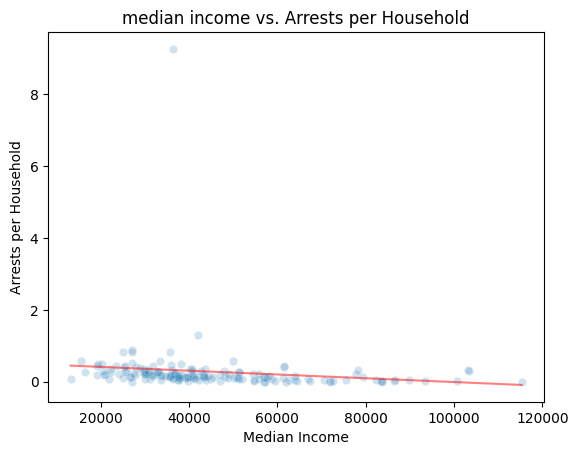

In [ ]:
sns.scatterplot(x=combined_frame['median_income'], y=combined_frame['arrests_per_household'], alpha = 0.2)

# Generate X values for the regression line
X_plot = np.linspace(
    combined_frame['median_income'].min(),
    combined_frame['median_income'].max(),
    100
).reshape(-1, 1)

# Predict corresponding y values for the regression line
y_plot = income_model.predict(X_plot)

# Plot the regression line
plt.plot(X_plot, y_plot, color='red', label='Regression Line', alpha = 0.5)


plt.title('median income vs. Arrests per Household')
plt.xlabel('Median Income')
plt.ylabel('Arrests per Household')
plt.show()


#**Predictor: Streetlights per household**
# **Target: arrests per household**

In order to determine which model is the best to use for our data, we will implement three different types of models and choose the best one based on mean square error average after a k-fold validation

In [ ]:
# Define predictors and target
X = combined_frame[['streetlights_per_household']] # Streetlight as predictor
y = combined_frame['arrests_per_household'] # arrest count as target


# Perform K-Fold cross-validation for Linear Regression
linear_cv_scores = cross_val_score(linear_model, X, y, cv=kf, scoring=mse_scorer)
linear_avg_mse = np.mean(linear_cv_scores)

# Perform K-Fold cross-validation for Decision Tree
tree_cv_scores = cross_val_score(tree_model, X, y, cv=kf, scoring=mse_scorer)
tree_avg_mse = np.mean(tree_cv_scores)

# Perform K-Fold cross-validation for Random Forest
forest_cv_scores = cross_val_score(forest_model, X, y, cv=kf, scoring=mse_scorer)
forest_avg_mse = np.mean(forest_cv_scores)

# Print average MSE for each model
print(f"Linear Regression Average MSE: {linear_avg_mse:.4f}")
print(f"Decision Tree Average MSE: {tree_avg_mse:.4f}")
print(f"Random Forest Average MSE: {forest_avg_mse:.4f}")


Linear Regression Average MSE: 0.3180
Decision Tree Average MSE: 0.4493
Random Forest Average MSE: 0.4894


Due to linear regression having the lowest MSE score, we will use linear regression to train a model with a train_test_split.

In [ ]:
# Split the data into training and test sets (using random seed of 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

# Initialize Linear Regression model
streetlight_model = LinearRegression()

# Fit the model on the training data
streetlight_model.fit(X_train, y_train)

# Evaluate the model on the test data
predictions_streetlights = streetlight_model.predict(X_test)

# Evaluate performance metrics
mse_streetlights = mean_squared_error(y_test, predictions_streetlights)
r2_streetlights = r2_score(y_test, predictions_streetlights)

# Results
results_streetlights = {
    "Test Data MSE": mse_streetlights,
    "Test Data R^2": r2_streetlights,
}

results_streetlights


{'Test Data MSE': 0.03461803679386572, 'Test Data R^2': -0.14093790867308398}

Make plot of data + line of best fit

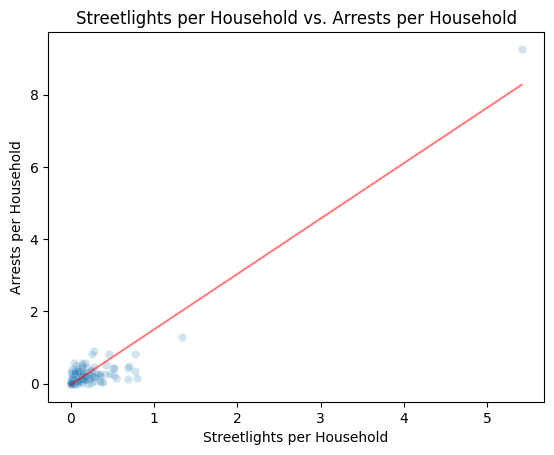

In [ ]:
sns.scatterplot(x=combined_frame['streetlights_per_household'], y=combined_frame['arrests_per_household'], alpha = 0.2)

# Generate X values for the regression line
X_plot = np.linspace(
    combined_frame['streetlights_per_household'].min(),
    combined_frame['streetlights_per_household'].max(),
    100
).reshape(-1, 1)

# Predict corresponding y values for the regression line
y_plot = streetlight_model.predict(X_plot)

# Plot the regression line
plt.plot(X_plot, y_plot, color='red', label='Regression Line', alpha = 0.5)


plt.title('Streetlights per Household vs. Arrests per Household')
plt.xlabel('Streetlights per Household')
plt.ylabel('Arrests per Household')
plt.show()


#**Predictor: neighborhood median income and streetlights per household**
# **Target: arrests per household**

In order to determine which model is the best to use for our data, we will implement three different types of models and choose the best one based on mean square error average after a k-fold validation

In [ ]:
# Define predictors and target
X_combined = combined_frame[['median_income', 'streetlights_per_household']] # Income as predictor
y = combined_frame['arrests_per_household'] # Arrest count as target


# Perform K-Fold cross-validation for Linear Regression
linear_cv_scores = cross_val_score(linear_model, X_combined, y, cv=kf, scoring=mse_scorer)
linear_avg_mse = np.mean(linear_cv_scores)

# Perform K-Fold cross-validation for Decision Tree
tree_cv_scores = cross_val_score(tree_model, X_combined, y, cv=kf, scoring=mse_scorer)
tree_avg_mse = np.mean(tree_cv_scores)

# Perform K-Fold cross-validation for Random Forest
forest_cv_scores = cross_val_score(forest_model, X_combined, y, cv=kf, scoring=mse_scorer)
forest_avg_mse = np.mean(forest_cv_scores)

# Print average MSE for each model
print(f"Linear Regression Average MSE: {linear_avg_mse:.4f}")
print(f"Decision Tree Average MSE: {tree_avg_mse:.4f}")
print(f"Random Forest Average MSE: {forest_avg_mse:.4f}")


Linear Regression Average MSE: 0.3398
Decision Tree Average MSE: 0.4617
Random Forest Average MSE: 0.4843


Due to linear regression having the lowest MSE score, we will use linear regression to train a model with a train_test_split.

In [ ]:
# Split the data into training and test sets (using random seed of 1000)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y, test_size=0.2, random_state=1000
)

# Initialize Linear Regression model
combined_model = LinearRegression()

# Fit the model on the training data
combined_model.fit(X_train_combined, y_train_combined)

# Evaluate the model on the test data
predictions_combined = combined_model.predict(X_test_combined)

# Evaluate performance metrics
mse_combined = mean_squared_error(y_test_combined, predictions_combined)
r2_combined = r2_score(y_test_combined, predictions_combined)

# Results
results_combined = {
    "Test Data MSE": mse_combined,
    "Test Data R^2": r2_combined
}

results_combined


{'Test Data MSE': 0.0360652401318171, 'Test Data R^2': -0.18863469632337426}

Make plot of 3d data + plane of best fit

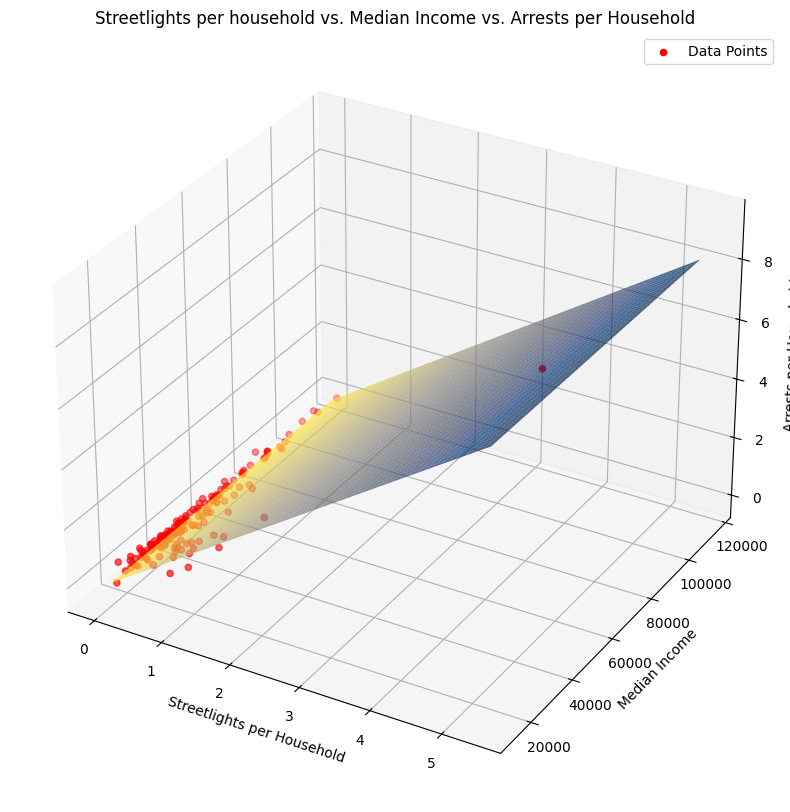

In [ ]:
# Generate grid data for predictors
streetlights_grid = np.linspace(combined_frame['streetlights_per_household'].min(), combined_frame['streetlights_per_household'].max(), 50)
income_grid = np.linspace(combined_frame['median_income'].min(), combined_frame['median_income'].max(), 50)
grid_streetlights, grid_income = np.meshgrid(streetlights_grid, income_grid)

# Flatten the grids and create a combined predictor set
grid_combined = np.column_stack([grid_income.ravel(), grid_streetlights.ravel()])

# Predict nighttime arrests for each grid point
grid_predictions = combined_model.predict(grid_combined).reshape(grid_streetlights.shape)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(grid_streetlights, grid_income, grid_predictions, cmap='cividis_r', alpha=0.7)

# Scatter the actual data points
ax.scatter(
    combined_frame['streetlights_per_household'],
    combined_frame['median_income'],
    combined_frame['arrests_per_household'],
    color='red', label='Data Points'
)

# Add labels and title
ax.set_title('Streetlights per household vs. Median Income vs. Arrests per Household')
ax.set_xlabel('Streetlights per Household')
ax.set_ylabel('Median Income')
ax.set_zlabel('Arrests per Household')

plt.legend()
plt.show()


#**Predictor: neighborhood income median income**
# **Target: night time (between sunset and sunrise) arrests per household**

In order to determine which model is the best to use for our data, we will implement three different types of models and choose the best one based on mean square error average after a k-fold validation

In [ ]:
# Define predictors and target
X_night = combined_frame[['median_income']] # Streetlight as predictor
y_night = combined_frame['nighttime_arrests_per_household'] # Arrest count as target


# Perform K-Fold cross-validation for Linear Regression
linear_cv_scores = cross_val_score(linear_model, X_night, y_night, cv=kf, scoring=mse_scorer)
linear_avg_mse = np.mean(linear_cv_scores)

# Perform K-Fold cross-validation for Decision Tree
tree_cv_scores = cross_val_score(tree_model, X_night, y_night, cv=kf, scoring=mse_scorer)
tree_avg_mse = np.mean(tree_cv_scores)

# Perform K-Fold cross-validation for Random Forest
forest_cv_scores = cross_val_score(forest_model, X_night, y_night, cv=kf, scoring=mse_scorer)
forest_avg_mse = np.mean(forest_cv_scores)

# Print average MSE for each model
print(f"Linear Regression Average MSE: {linear_avg_mse:.4f}")
print(f"Decision Tree Average MSE: {tree_avg_mse:.4f}")
print(f"Random Forest Average MSE: {forest_avg_mse:.4f}")


Linear Regression Average MSE: 0.0884
Decision Tree Average MSE: 0.0967
Random Forest Average MSE: 0.0955


Due to linear regression having the lowest MSE score, we will use linear regression to train a model with a train_test_split.

In [ ]:
# Split the nighttime data into training and test sets (using random seed of 1000)
X_train_night, X_test_night, y_train_night, y_test_night = train_test_split(
    X_night, y, test_size=0.2, random_state=1000
)

# Initialize the Linear Regression model
nighttime_income_model = LinearRegression()

# Fit the model on the training nighttime data
nighttime_income_model.fit(X_train_night, y_train_night)

# Evaluate the model on the test nighttime data
predictions_night_income = nighttime_income_model.predict(X_test_night)

# Evaluate performance metrics
mse_night_income = mean_squared_error(y_test_night, predictions_night_income)
r2_night_income = r2_score(y_test_night, predictions_night_income)

# Results
results_night_income = {
    "Nighttime MSE": mse_night_income,
    "Nighttime R^2": r2_night_income
}

results_night_income


{'Nighttime MSE': 0.035503059626454885, 'Nighttime R^2': -0.17010640559724055}

Make plot of data + line of best fit

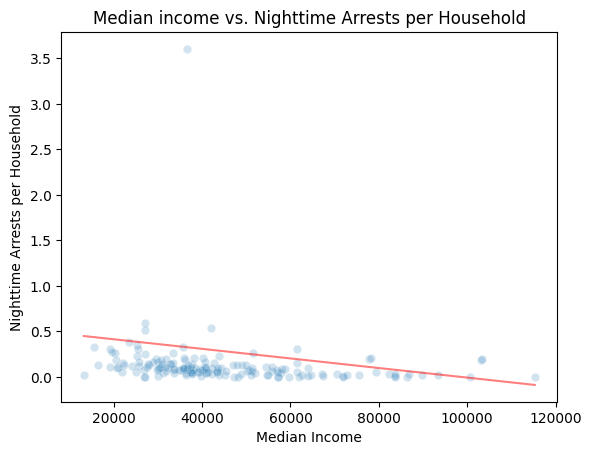

In [ ]:
sns.scatterplot(x=combined_frame['median_income'], y=combined_frame['nighttime_arrests_per_household'], alpha = 0.2)

# Generate X values for the regression line
X_plot = np.linspace(
    combined_frame['median_income'].min(),
    combined_frame['median_income'].max(),
    100
).reshape(-1, 1)

# Predict corresponding y values for the regression line
y_plot = income_model.predict(X_plot)

# Plot the regression line
plt.plot(X_plot, y_plot, color='red', label='Regression Line', alpha = 0.5)


plt.title('Median income vs. Nighttime Arrests per Household')
plt.xlabel('Median Income')
plt.ylabel('Nighttime Arrests per Household')
plt.show()


#**Predictor: streetlights per household**
# **Target: night time (between sunset and sunrise) arrests per household**

In order to determine which model is the best to use for our data, we will implement three different types of models and choose the best one based on mean square error average after a k-fold validation

In [ ]:
# Define predictors and target
X_night_streetlights = combined_frame[['streetlights_per_household']] # Streetlight as predictor
y_night = combined_frame['nighttime_arrests_per_household'] # Arrest count as target


# Perform K-Fold cross-validation for Linear Regression
linear_cv_scores = cross_val_score(linear_model, X_night_streetlights, y_night, cv=kf, scoring=mse_scorer)
linear_avg_mse = np.mean(linear_cv_scores)

# Perform K-Fold cross-validation for Decision Tree
tree_cv_scores = cross_val_score(tree_model, X_night_streetlights, y_night, cv=kf, scoring=mse_scorer)
tree_avg_mse = np.mean(tree_cv_scores)

# Perform K-Fold cross-validation for Random Forest
forest_cv_scores = cross_val_score(forest_model, X_night_streetlights, y_night, cv=kf, scoring=mse_scorer)
forest_avg_mse = np.mean(forest_cv_scores)

# Print average MSE for each model
print(f"Linear Regression Average MSE: {linear_avg_mse:.4f}")
print(f"Decision Tree Average MSE: {tree_avg_mse:.4f}")
print(f"Random Forest Average MSE: {forest_avg_mse:.4f}")


Linear Regression Average MSE: 0.0424
Decision Tree Average MSE: 0.0741
Random Forest Average MSE: 0.0787


Due to linear regression having the lowest MSE score, we will use linear regression to train a model with a train_test_split.

In [ ]:
# Split the nighttime streetlight data into training and test sets (using random seed of 1000)
X_train_night_streetlights, X_test_night_streetlights, y_train_night_streetlights, y_test_night_streetlights = train_test_split(
    X_night_streetlights, y_night, test_size=0.2, random_state=1000
)

# Initialize the Linear Regression model
nighttime_streetlight_model = LinearRegression()

# Fit the model on the training nighttime streetlight data
nighttime_streetlight_model.fit(X_train_night_streetlights, y_train_night_streetlights)

# Evaluate the model on the test nighttime streetlight data
predictions_night_streetlights = nighttime_streetlight_model.predict(X_test_night_streetlights)

# Evaluate performance metrics
mse_night_streetlights = mean_squared_error(y_test_night_streetlights, predictions_night_streetlights)
r2_night_streetlights = r2_score(y_test_night_streetlights, predictions_night_streetlights)

# Results
results_night_streetlights = {
    "Nighttime MSE": mse_night_streetlights,
    "Nighttime R^2": r2_night_streetlights
}

results_night_streetlights


{'Nighttime MSE': 0.0072908906912114045, 'Nighttime R^2': -0.19001101308840362}

Make plot of data + line of best fit

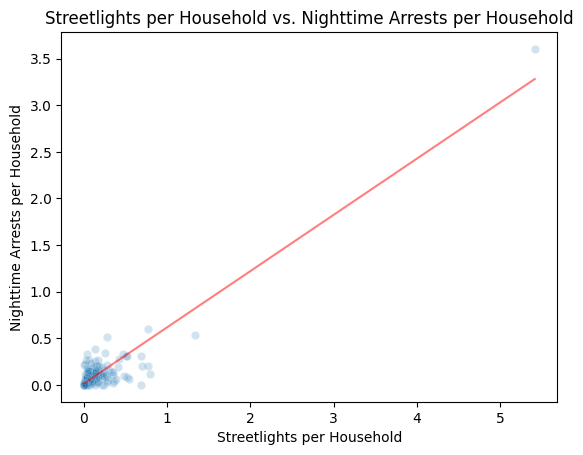

In [ ]:
sns.scatterplot(x=combined_frame['streetlights_per_household'], y=combined_frame['nighttime_arrests_per_household'], alpha = 0.2)

# Generate X values for the regression line
X_plot = np.linspace(
    combined_frame['streetlights_per_household'].min(),
    combined_frame['streetlights_per_household'].max(),
    100
).reshape(-1, 1)

# Predict corresponding y values for the regression line
y_plot = nighttime_streetlight_model.predict(X_plot)

# Plot the regression line
plt.plot(X_plot, y_plot, color='red', label='Regression Line', alpha = 0.5)


plt.title('Streetlights per Household vs. Nighttime Arrests per Household')
plt.xlabel('Streetlights per Household')
plt.ylabel('Nighttime Arrests per Household')
plt.show()



#**Predictor: neighborhood median income and streetlights per household**
# **Target: night time (between sunset and sunrise) arrests per household**

In order to determine which model is the best to use for our data, we will implement three different types of models and choose the best one based on mean square error average after a k-fold validation

In [ ]:
# Define predictors and target
X_night_combined = combined_frame[['median_income', 'streetlights_per_household']] # Streetlight as predictor
y_night = combined_frame['nighttime_arrests_per_household'] # Arrests count as target


# Perform K-Fold cross-validation for Linear Regression
linear_cv_scores = cross_val_score(linear_model, X_night_combined, y_night, cv=kf, scoring=mse_scorer)
linear_avg_mse = np.mean(linear_cv_scores)

# Perform K-Fold cross-validation for Decision Tree
tree_cv_scores = cross_val_score(tree_model, X_night_combined, y_night, cv=kf, scoring=mse_scorer)
tree_avg_mse = np.mean(tree_cv_scores)

# Perform K-Fold cross-validation for Random Forest
forest_cv_scores = cross_val_score(forest_model, X_night_combined, y_night, cv=kf, scoring=mse_scorer)
forest_avg_mse = np.mean(forest_cv_scores)

# Print average MSE for each model
print(f"Linear Regression Average MSE: {linear_avg_mse:.4f}")
print(f"Decision Tree Average MSE: {tree_avg_mse:.4f}")
print(f"Random Forest Average MSE: {forest_avg_mse:.4f}")


Linear Regression Average MSE: 0.0461
Decision Tree Average MSE: 0.0746
Random Forest Average MSE: 0.0795


Due to linear regression having the lowest MSE score, we will use linear regression to train a model with a train_test_split.

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_night_combined,  # Predictor variables
    y_night,           # Target variable
    test_size=0.2,     # Proportion of data to reserve for testing (20% here)
    random_state=1000  # Seed for reproducibility
)

# Initialize the Linear Regression model
nighttime_combined_model = LinearRegression()

# Fit the model on the training data
nighttime_combined_model.fit(X_train, y_train)

# Make predictions on the test data
predictions_test = nighttime_combined_model.predict(X_test)

# Evaluate the model on the test data
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

# Results
results_test = {
    "Test MSE": mse_test,
    "Test R^2": r2_test,
}

# Print results
print(results_test)


{'Test MSE': 0.007811375169952957, 'Test R^2': -0.27496390678500515}


Make plot of 3d data + plane of best fit

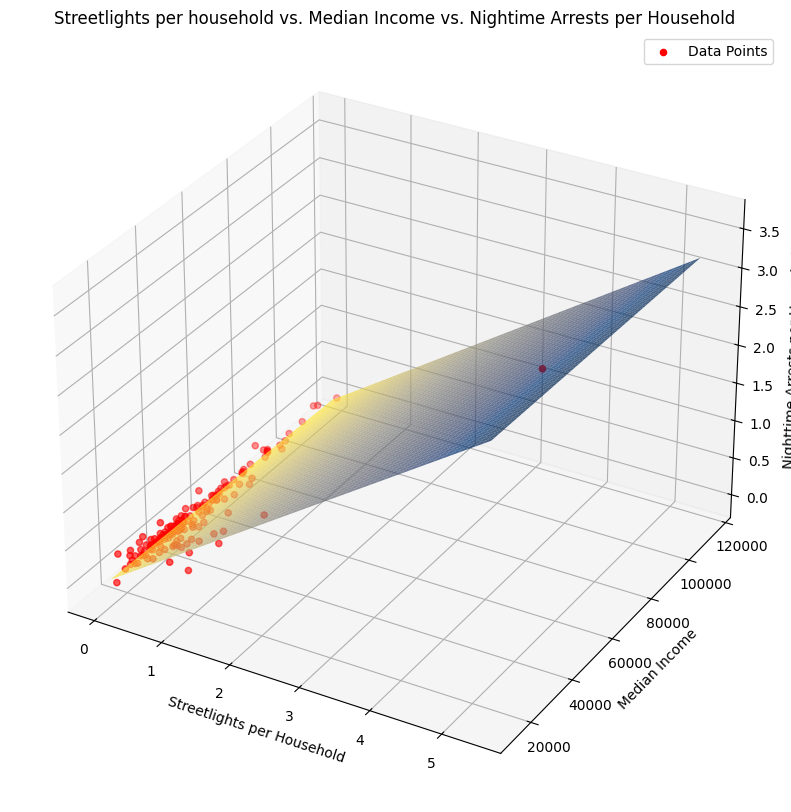

In [ ]:
# Generate grid data for predictors
streetlights_grid = np.linspace(combined_frame['streetlights_per_household'].min(), combined_frame['streetlights_per_household'].max(), 50)
income_grid = np.linspace(combined_frame['median_income'].min(), combined_frame['median_income'].max(), 50)
grid_streetlights, grid_income = np.meshgrid(streetlights_grid, income_grid)

# Flatten the grids and create a combined predictor set
grid_combined = np.column_stack([grid_income.ravel(), grid_streetlights.ravel()])

# Predict nighttime arrests for each grid point
grid_predictions = nighttime_combined_model.predict(grid_combined).reshape(grid_streetlights.shape)

# Create a 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(grid_streetlights, grid_income, grid_predictions, cmap='cividis_r', alpha=0.7)

# Scatter the actual data points
ax.scatter(
    combined_frame['streetlights_per_household'],
    combined_frame['median_income'],
    combined_frame['nighttime_arrests_per_household'],
    color='red', label='Data Points'
)

# Add labels and title
ax.set_title('Streetlights per household vs. Median Income vs. Nightime Arrests per Household')
ax.set_xlabel('Streetlights per Household')
ax.set_ylabel('Median Income')
ax.set_zlabel('Nighttime Arrests per Household')

plt.legend()
plt.show()


# Results

**All Arrest Model Testing:**

  Trained on Income: Linear Regression Average MSE: 0.5636
Decision Tree Average MSE: 0.5960
Random Forest Average MSE: 0.5943

  Trained on Streetlights per household: Linear Regression Average MSE: 0.3180
Decision Tree Average MSE: 0.4493
Random Forest Average MSE: 0.4894

  Trained on Income and Streetlights per household: Linear Regression Average MSE: 0.3398
Decision Tree Average MSE: 0.4617
Random Forest Average MSE: 0.4843

**Best Model (Linear Regression) Testing Results All Arrests:**

Trained on Income: 'Test Data MSE': 0.035503059626454885, 'Test Data R^2': -0.17010640559724055

Trained on Streetlights per household: 'Test Data MSE': 0.03461803679386572, 'Test Data R^2': -0.14093790867308398

Trained on Income and Streetlights per household: 'Test Data MSE': 0.0360652401318171, 'Test Data R^2': -0.18863469632337426

**Nighttime Arrest Model Testing:**

  Trained on Income: Linear Regression Average MSE: Linear Regression Average MSE: 0.0884
Decision Tree Average MSE: 0.0967
Random Forest Average MSE: 0.0955

  Trained on Streetlights per household: Linear Regression Average MSE: 0.0424
Decision Tree Average MSE: 0.0741
Random Forest Average MSE: 0.0787

  Trained on Income and Streetlights per household: Linear Regression Average MSE: 0.0461
Decision Tree Average MSE: 0.0746
Random Forest Average MSE: 0.0795

**Best Model (Linear Regression) Testing Results Nighttime Arrests:**

Trained on Income: 'Test Data MSE': 'Nighttime MSE': 0.035503059626454885, 'Nighttime R^2': -0.17010640559724055

Trained on Streetlights per household: 'Nighttime MSE': 0.0072908906912114045, 'Nighttime R^2': -0.19001101308840362

Trained on Income and Streetlights per household: 'Test MSE': 0.007811375169952957, 'Test R^2': -0.27496390678500515

# Why linear regression is better than Decision trees and Random Forests in all of the cases?


Linear regression is the best fit in all cases because it excels when the relationships between predictors (e.g., income, streetlights) and the target variable (arrest rates) are approximately linear, which appears to be true for this dataset. Operating with a high bias, low variance tradeoff, linear regression avoids overfitting while providing stable and consistent predictions. The predictors in this study are well-scaled: income is a continuous variable with natural scaling, and streetlight counts are normalized, avoiding extreme outliers. Properly scaled predictors reduce bias in the coefficient estimates and improve prediction accuracy. Although income-only models have low R^2, adding income to streetlight data slightly improves AMSE, indicating a weak but linear contribution. The strong R^2 scores in streetlight-only models suggest a direct and proportional relationship with arrest rates that linear regression captures effectively. In contrast, alternative models like Decision Trees or Random Forests, which excel in capturing non-linear relationships, may overfit the data when the underlying behavior is predominantly linear or when the sample size per neighborhood is small, even if the overall dataset is large. These factors collectively explain why linear regression is the most appropriate choice for this analysis.


## Conclusion


This project explored the relationship between median neighborhood income, density of street lights, and arrest rates in Tucson neighborhoods. Through our modeling, we demonstrated that streetlight presence significantly correlates with increased arrest rates, both during nighttime and across all times of the day. Linear regression proved to be an effective tool for capturing these relationships due to its simplicity, achieving the best average Mean Squared Error (AMSE) across multiple models. While income alone was found to be a weak predictor, its inclusion alongside streetlight data did not cause significant change.

However despite income and crime being strongly correlated with one another, all of our models showed a negative r^2 value. This is because of an outlier in our dataset, the downtown tucson neighborhood. This neighborhood draws many visitors for it's bars and nightlife, which drive arrests up, however the households are very low. This made it an outlier after we normalized our data. Outliers themselves have a large affect on r^2 values and we believe this neighborhood swayed our data. Future studies on this topic and Tucson should consider normalization methods that don't cause this neighborhood to be a large outlier.

Despite this, we can still say the streetlights in Tucson is a good predictor of increased arrests rates in an area, due to lower MSE and higher R^2 values than when traditional predictors such as income are used. This is a unique trait to Tucson, and contrary to most major cities in the US. Upon reasearch of the city and it's streetlight policies, we discovered that streetlights were being disproportionately placed in high crime areas. Likely leading to the positive correlation between crime and streetlights that is unique to Tucson. These predictive policing policies heavily affect the percieved effectiveness of streetlights to prevent crime in Tucson, which is why we had to change our intial hypothesis, to match the needs of Tucson.

Relevant future work to this project could include incorporating additional predictors or temporal analysis. Including predictors such as population density, crime severity, and land use patterns could provide a deeper understanding of crime dynamics. Extending the study to include time-series analysis or examining crime seasonality could reveal long-term trends and periodic patterns.

# References
Anser, M.K., Yousaf, Z., Nassani, A.A. et al. Dynamic linkages between poverty, inequality, crime, and social expenditures in a panel of 16 countries: two-step GMM estimates. Economic Structures 9, 43 (2020). https://doi.org/10.1186/s40008-020-00220-6

FBI. “FBI Crime Data Explorer.” Cde.Ucr.Cjis.Gov, 2024, cde.ucr.cjis.gov/LATEST/webapp/#/pages/explorer/crime/crime-trend.
Tucson/Pima County. 2023 City of Tucson/Pima County Outdoor Lighting Code, 2023, www.tucsonaz.gov/files/sharedassets/public/v/1/pdsd/documents/boards-committees-commissions/olcc/013024/olcc-draft.pdf.
Welsh, B.C. and Farrington, D.P. (2008), Effects of Improved Street Lighting on Crime. Campbell Systematic Reviews, 4: 1-51. https://doi.org/10.4073/csr.2008.13

Welsh, B. C., Farrington, D. P., & Douglas, S. (2022). The impact and policy relevance of street lighting for crime prevention: A Systematic review based on a half-century of evaluation research. Criminology & Public Policy, 21, 739–765. https://doi.org/10.1111/1745-9133.12585
